# MobilePrice_EDA_TreeModels_and_Ensembles

1. Изучение структуры и содержимого набора данных  
2. Подготовка данных для классификации:
   - Обработка и удаление нерелевантных или дублирующихся данных  
   - Отделение целевого признака `price_range`
   - Разделение данных на обучающую и тестовую выборки  
3. Обучение модели `DecisionTreeClassifier`  
4. Оценка качества предсказаний с использованием метрик: accuracy, precision, recall, f1-score  
5. Визуализация дерева решений и анализ важности признаков  
6. Нормализация данных с последующим обучением модели на нормализованных данных  
7. Подбор гиперпараметров модели с помощью `RandomizedSearchCV`  
8. Построение модели с оптимальными параметрами
9. Применение и сравнение ансамблевых методов:
    - `RandomForestClassifier`
    - `AdaBoostClassifier`
    - `GradientBoostingClassifier` / `HistGradientBoostingClassifier`
10. Stacking

## Импорт библиотек


In [86]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [87]:
warnings.filterwarnings("ignore")

## Загрузка датасета

In [88]:
test_df = pd.read_csv('/content/mobile_classification_test.csv')
train_df = pd.read_csv('/content/mobile_classification_train.csv')

In [89]:
train_df.shape, test_df.shape

((2000, 21), (1000, 21))

In [90]:
df = train_df.copy()

In [91]:
df.shape

(2000, 21)

## 1. Изучение структуры и содержимого набора данных

In [92]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Датасет предназначен для задачи классификации цен на мобильные телефоны. Каждая строка представляет собой отдельный смартфон с его техническими характеристиками. Цель — предсказать ценовую категорию телефона на основе этих характеристик.

In [93]:
df.shape

(2000, 21)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [95]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

### Целевая переменная

**price_range (0–3):**

0 — низкий сегмент

1 — средний сегмент

2 — высокий сегмент

3 — премиум-сегмент

### Признаки

1. **battery_power**: Емкость аккумулятора (мАч)

2. **blue**: Поддержка Bluetooth (1 — есть, 0 — нет)

3. **clock_speed**: Частота процессора (ГГц)

4. **dual_sim**: Поддержка двух SIM-карт (1 — да, 0 — нет)

5. **fc**: Разрешение фронтальной камеры (МП)

6. **four_g**: Поддержка 4G (1 — да, 0 — нет)

7. **int_memory**: Встроенная память (ГБ)

8. **m_dep**: Толщина устройства (см)

9. **mobile_wt**: Вес телефона (г)

10. **n_cores**: Количество ядер процессора

11. **pc**: Разрешение основной камеры (МП)

12. **px_height**: Высота экрана в пикселях

13. **px_width**: Ширина экрана в пикселях

14. **ram**: Объем оперативной памяти (МБ)

15. **sc_h**: Высота экрана (см)

16. **sc_w**: Ширина экрана (см)

17. **talk_time**: Время разговора (ч)

18. **three_g**: Поддержка 3G (1 — да, 0 — нет)

19. **touch_screen**: Сенсорный экран (1 — да, 0 — нет)

20. **wifi**: Поддержка Wi-Fi (1 — да, 0 — нет)

## 2. Преобразование датасета

In [96]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


### Пропущенные значения

In [97]:
df.isnull().sum()

,0
battery_power,0
blue,0
clock_speed,0
dual_sim,0
fc,0
four_g,0
int_memory,0
m_dep,0
mobile_wt,0
n_cores,0


Пропущенных значений нет

### Дубликаты

In [98]:
df.shape

(2000, 21)

In [99]:
df.drop_duplicates()
df.shape

(2000, 21)

Дубликатов нет

### Общая статистика

In [100]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


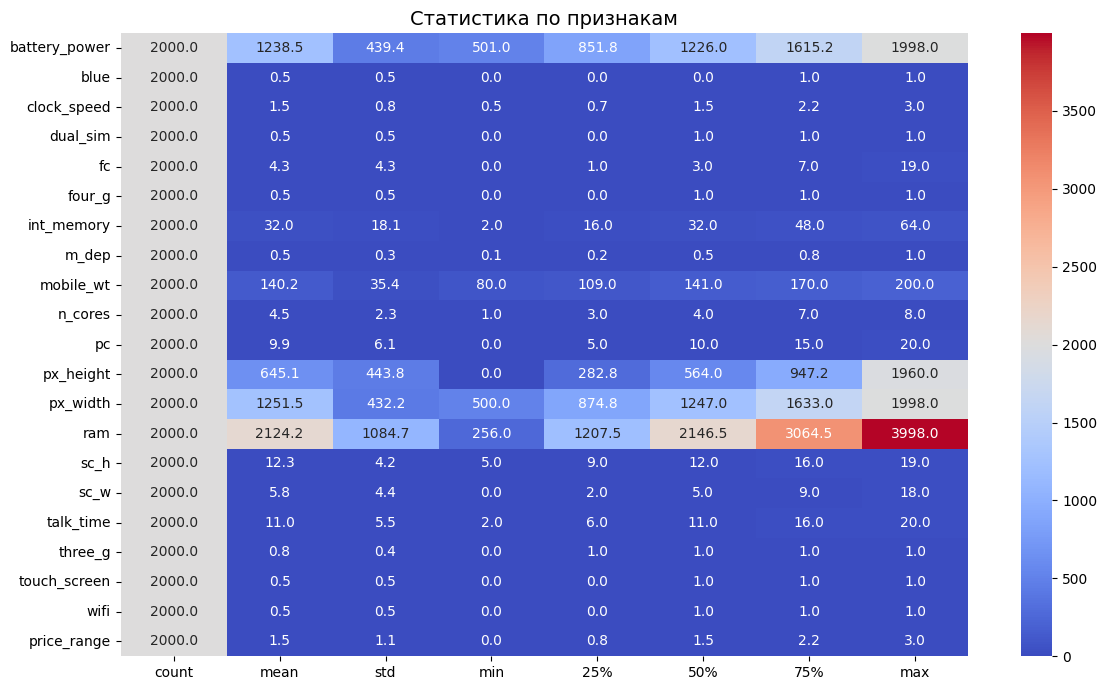

In [101]:
desc = df.describe().transpose()

# Строим тепловую карту
plt.figure(figsize=(12, 7))
sns.heatmap(desc, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Статистика по признакам", fontsize=14)
plt.tight_layout()
plt.show()

### Boxplot для всех признаков

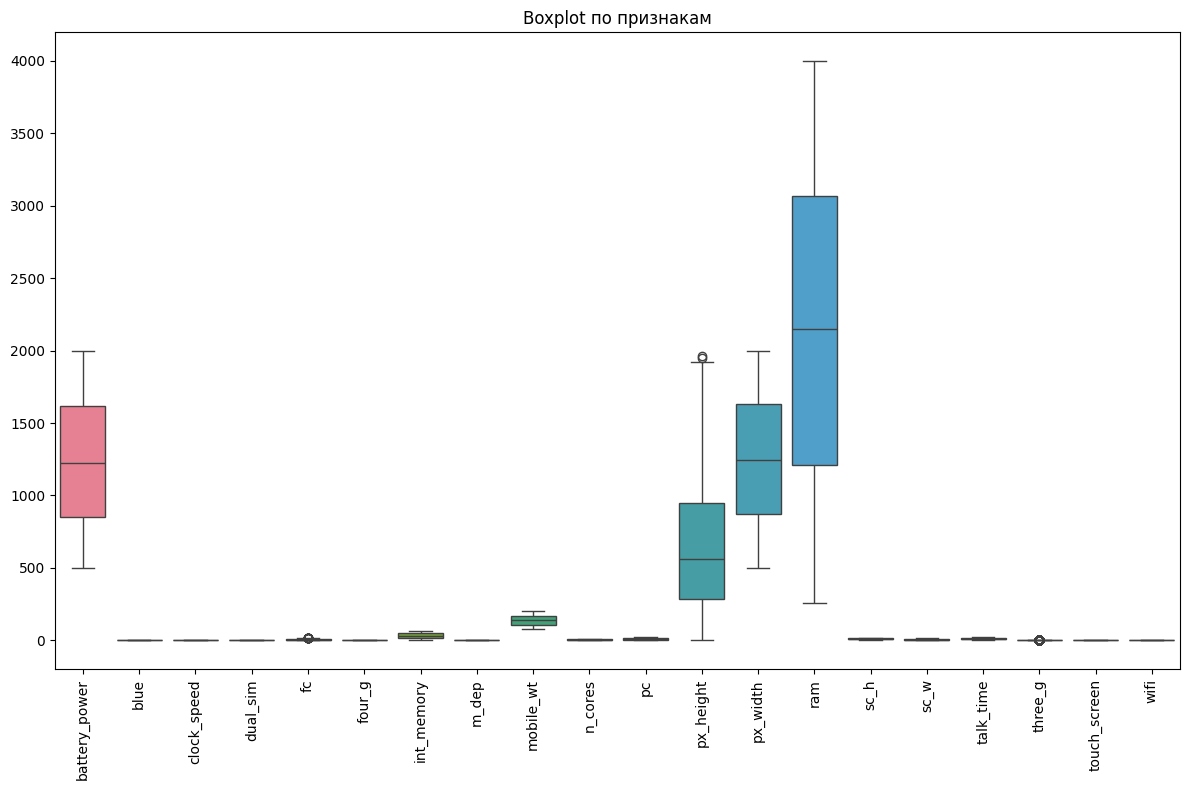

In [102]:
features = df.drop(columns=['price_range'])

# Boxplot для всех признаков
plt.figure(figsize=(12, 8))
sns.boxplot(data=features)
plt.xticks(rotation=90)
plt.title("Boxplot по признакам")
plt.tight_layout()
plt.show()

### Гистограммы

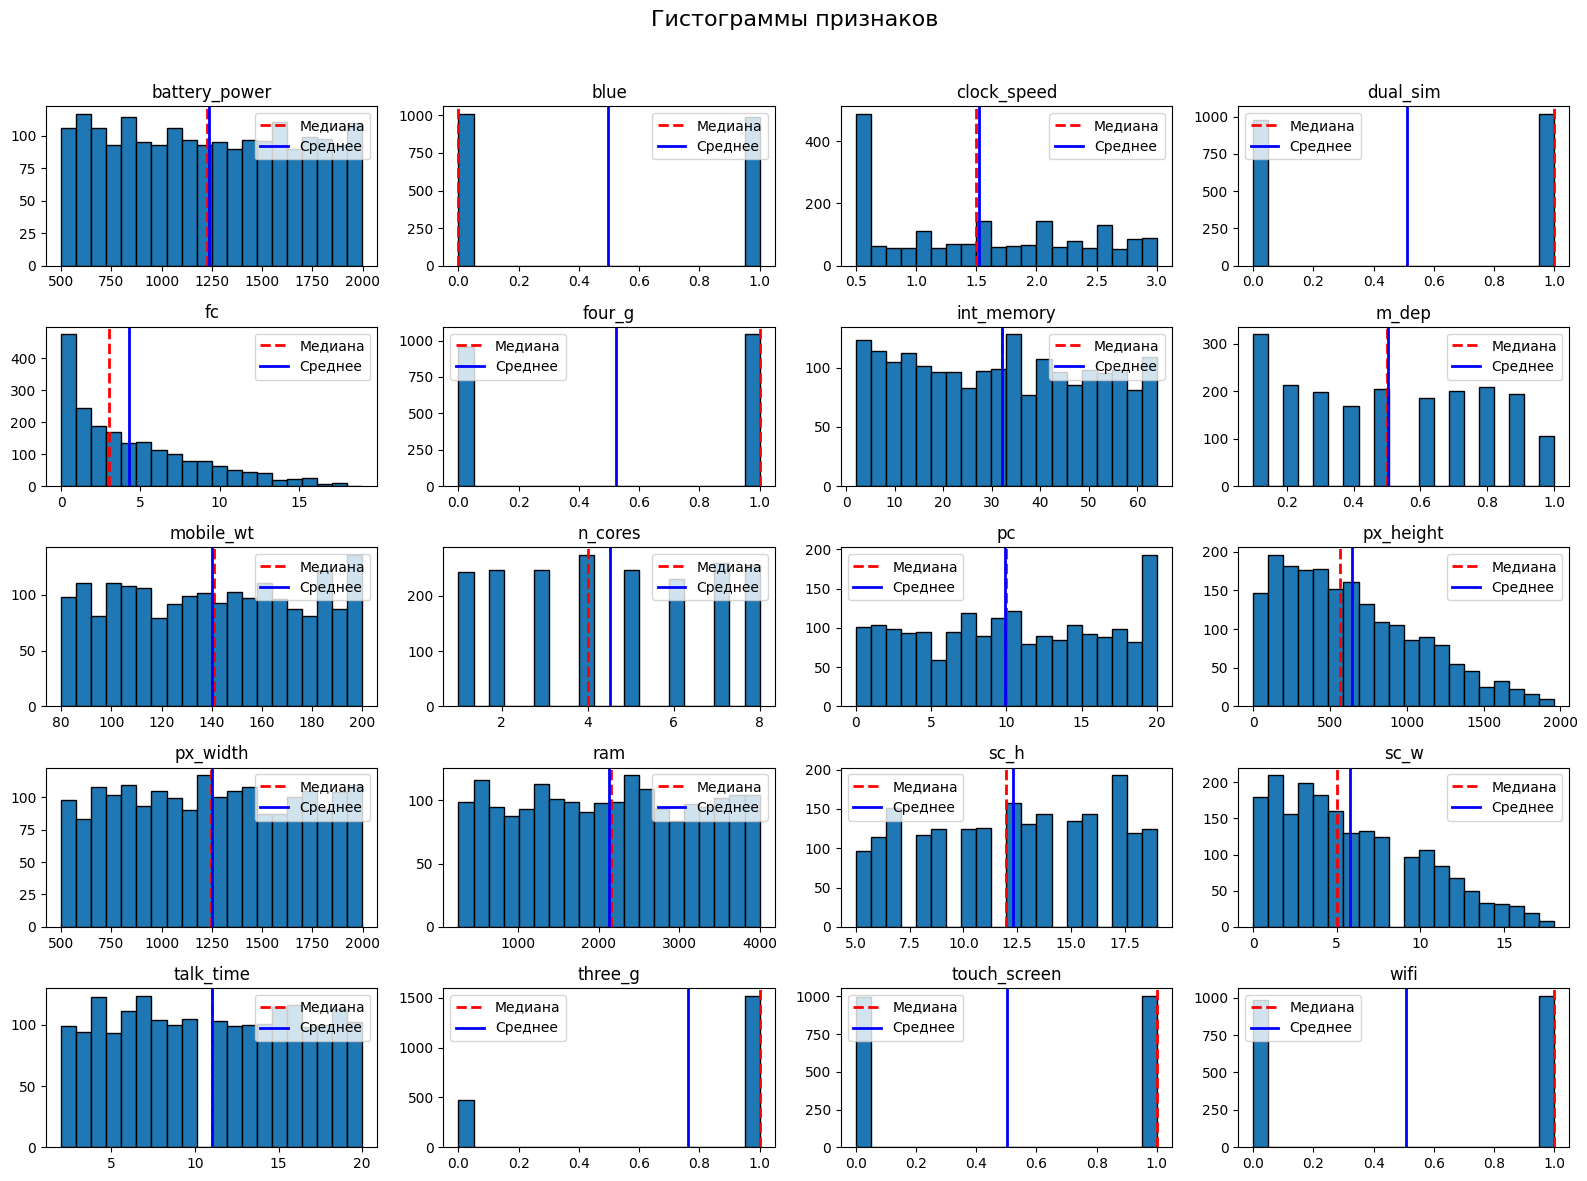

In [103]:
# Рисуем гистограммы
axes = features.hist(bins=20, figsize=(16, 12), grid=False, edgecolor='black')

plt.suptitle("Гистограммы признаков", fontsize=16)

# Проходимся по каждому признаку и соответствующей оси
for i, column in enumerate(features.columns):
    ax = axes.flatten()[i]
    median = features[column].median()
    mean = features[column].mean()

    ax.axvline(median, color='red', linestyle='dashed', linewidth=2, label='Медиана')
    ax.axvline(mean, color='blue', linestyle='solid', linewidth=2, label='Среднее')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Чтобы не перекрывался заголовок
plt.show()

In [104]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


### Кольцевые диаграммы

In [105]:
def create_plot_cat(feature):
    palette = sns.color_palette("Set2")
    value_counts = df[feature].value_counts()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5),
                                   gridspec_kw={'width_ratios': [1, 1]})

    ax1.pie(value_counts, autopct='%0.001f%%', startangle=90, pctdistance=0.85,
            colors=palette, labels=None)
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax1.add_artist(centre_circle)
    ax1.set_title(f'Кольцевая диаграмма для {feature}', fontsize=16)

    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2,
                palette=palette)
    ax2.set_title(f'Барчарты для {feature}', fontsize=16)
    ax2.set_xlabel(f"{feature}", fontsize=14)
    ax2.set_ylabel('Количество', fontsize=14)

    ax2.tick_params(axis='x')

    plt.tight_layout()
    plt.show()

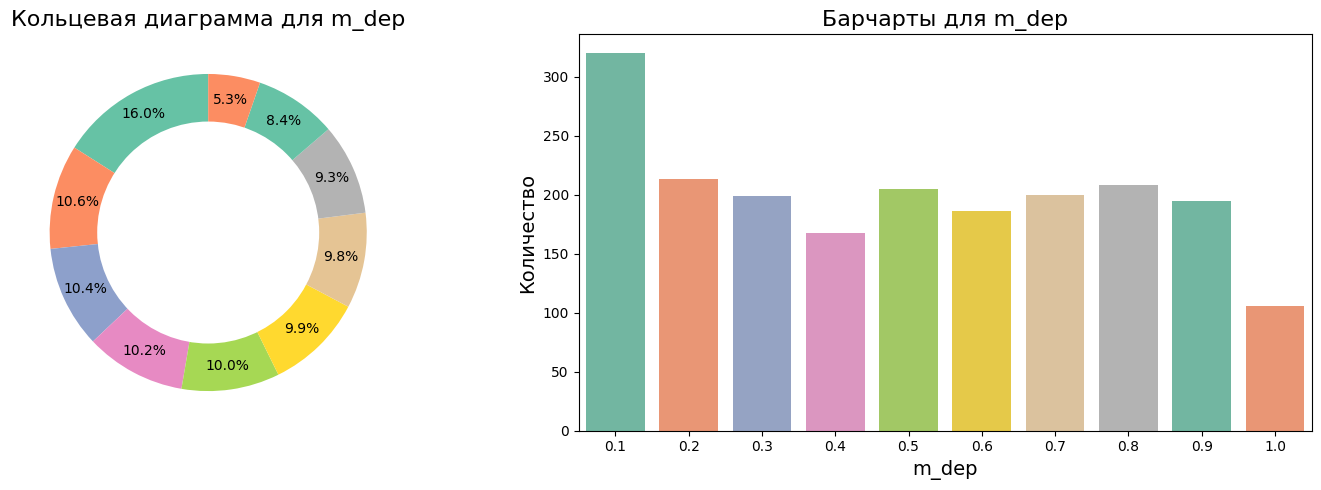

In [106]:
create_plot_cat("m_dep")

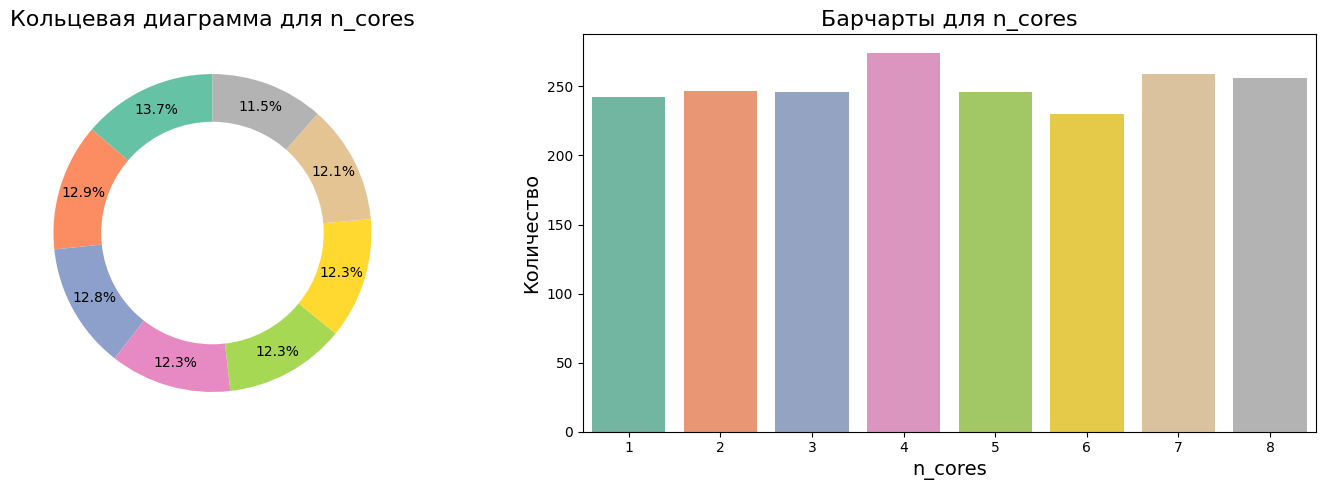

In [107]:
create_plot_cat("n_cores")

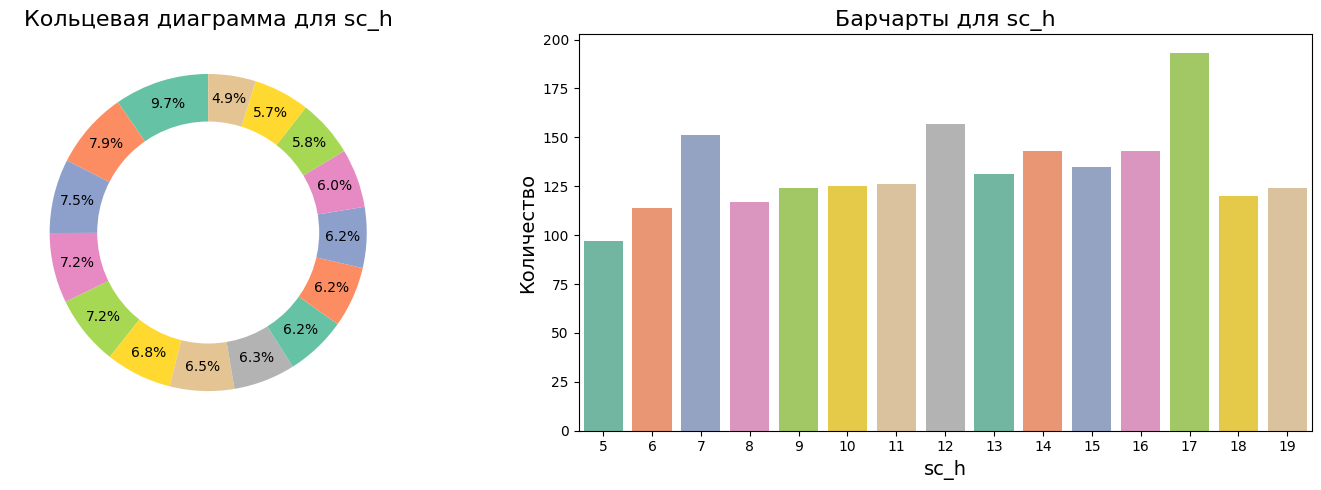

In [108]:
create_plot_cat("sc_h")

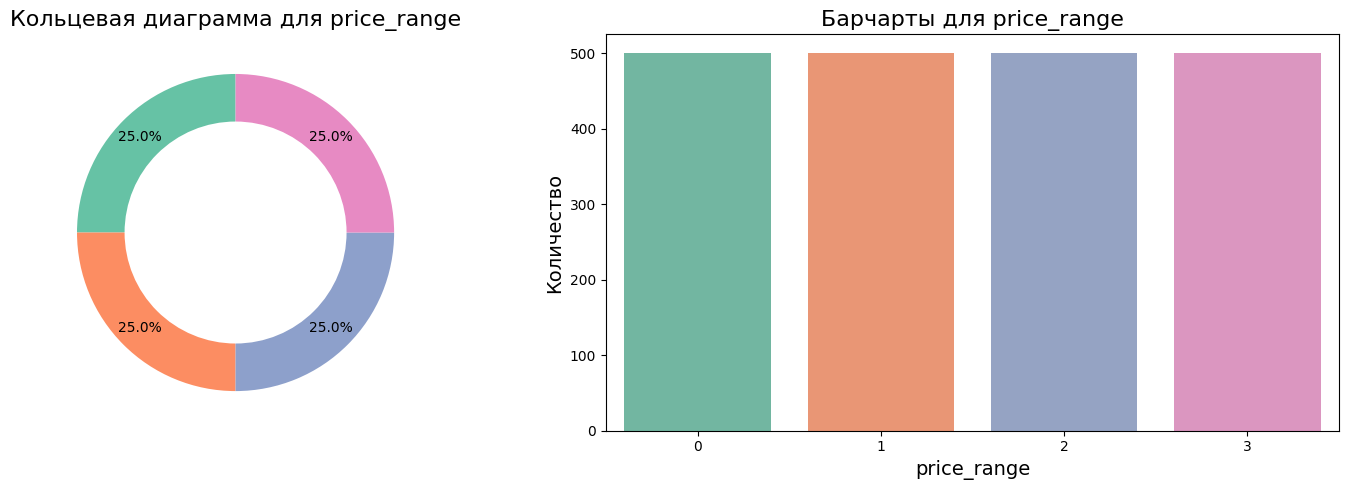

In [109]:
create_plot_cat("price_range")

### Корреляционная матрица

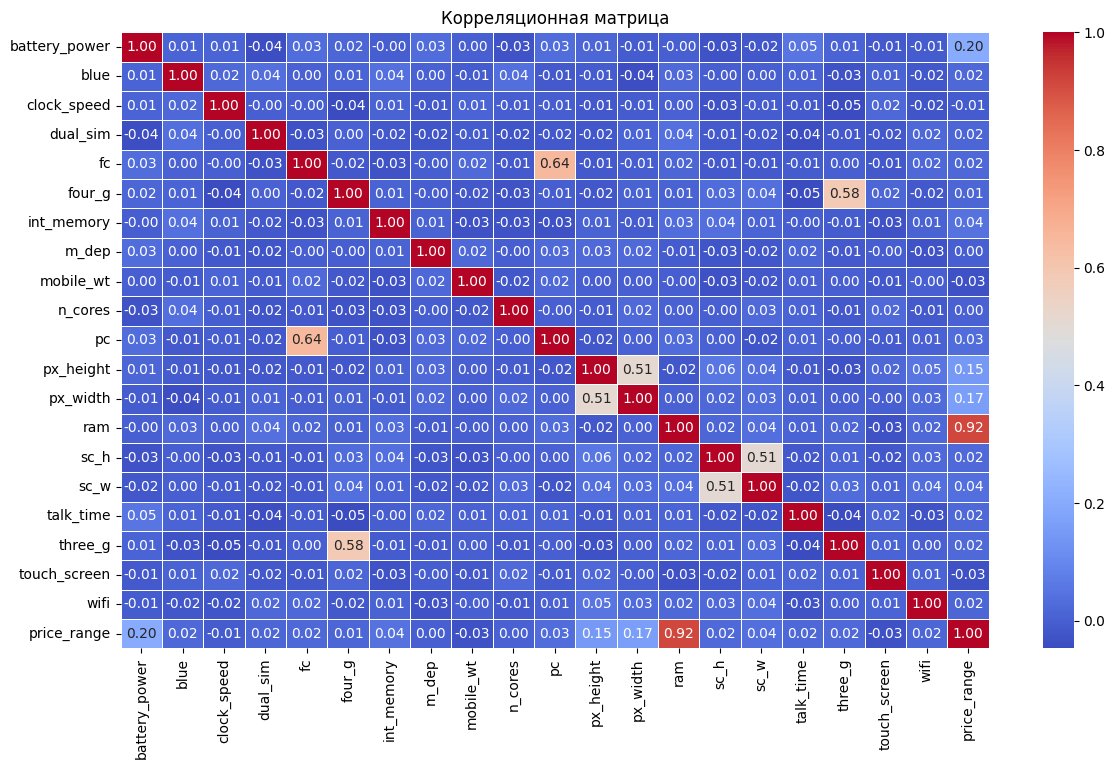

In [110]:
corr_matrix = df.corr()

# Построение графика
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

### Разделение на тренировочную и тестовую выборки

In [111]:
X = df.drop('price_range', axis=1)
y = df['price_range']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y            # сохраняем пропорции классов
)

## 3. Обучение модели DecisionTreeClassifier

In [113]:
# Создаём модель
clf = DecisionTreeClassifier(random_state=42)

In [114]:
# Обучаем модель на тренировочных данных
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [115]:
# Делаем предсказания на тестовых данных
y_pred = clf.predict(X_test)

## 4. Оценка точности

### Точность

In [116]:
# Оцениваем точность
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели Decision Tree: {accuracy:.4f}")

Точность модели Decision Tree: 0.8300


Модель дерева решений достигла точности 0.8300, что является хорошим результатом для многоклассовой классификации, подтверждающим, что модель эффективно различает классы в целом. Тем не менее, такая точность может быть улучшена, например, за счет настройки гиперпараметров или использования других методов.

### Матрица ошибок (Confusion Matrix)

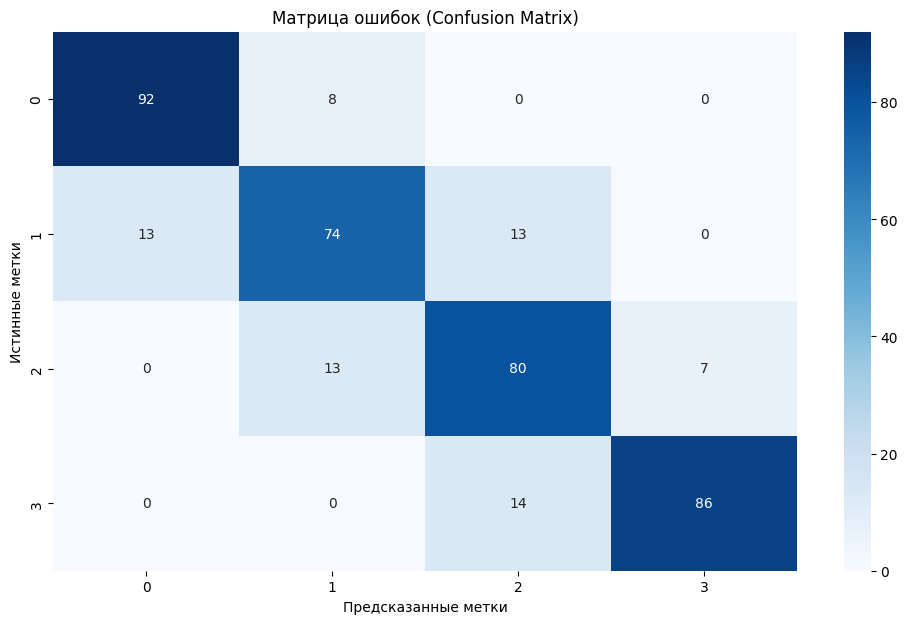

In [117]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

Из матрицы ошибок видно, что модель правильно классифицирует объекты класса 0 (92 верно предсказанных), но также допускает ошибки при классификации классов 1, 2 и 3. Для класса 1 модель ошибается чаще, классифицируя объекты этого класса как класс 0 и 2. Для класса 2 ошибки также присутствуют, причем объекты этого класса иногда классифицируются как класс 31.

### Отчёт по классификации

In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       100
           1       0.78      0.74      0.76       100
           2       0.75      0.80      0.77       100
           3       0.92      0.86      0.89       100

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



### ROC-AUC

In [119]:
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
print(f"\nROC-AUC: {roc_auc:.4f}")


ROC-AUC: 0.8867


ROC-AUC составляет 0.8867, что говорит о том, что модель хорошо различает классы. Площадь под кривой ROC подтверждает, что модель в целом способна эффективно разделять объекты разных классов, несмотря на некоторые сложности в классификации некоторых классов.

## 5. Визуализация модели

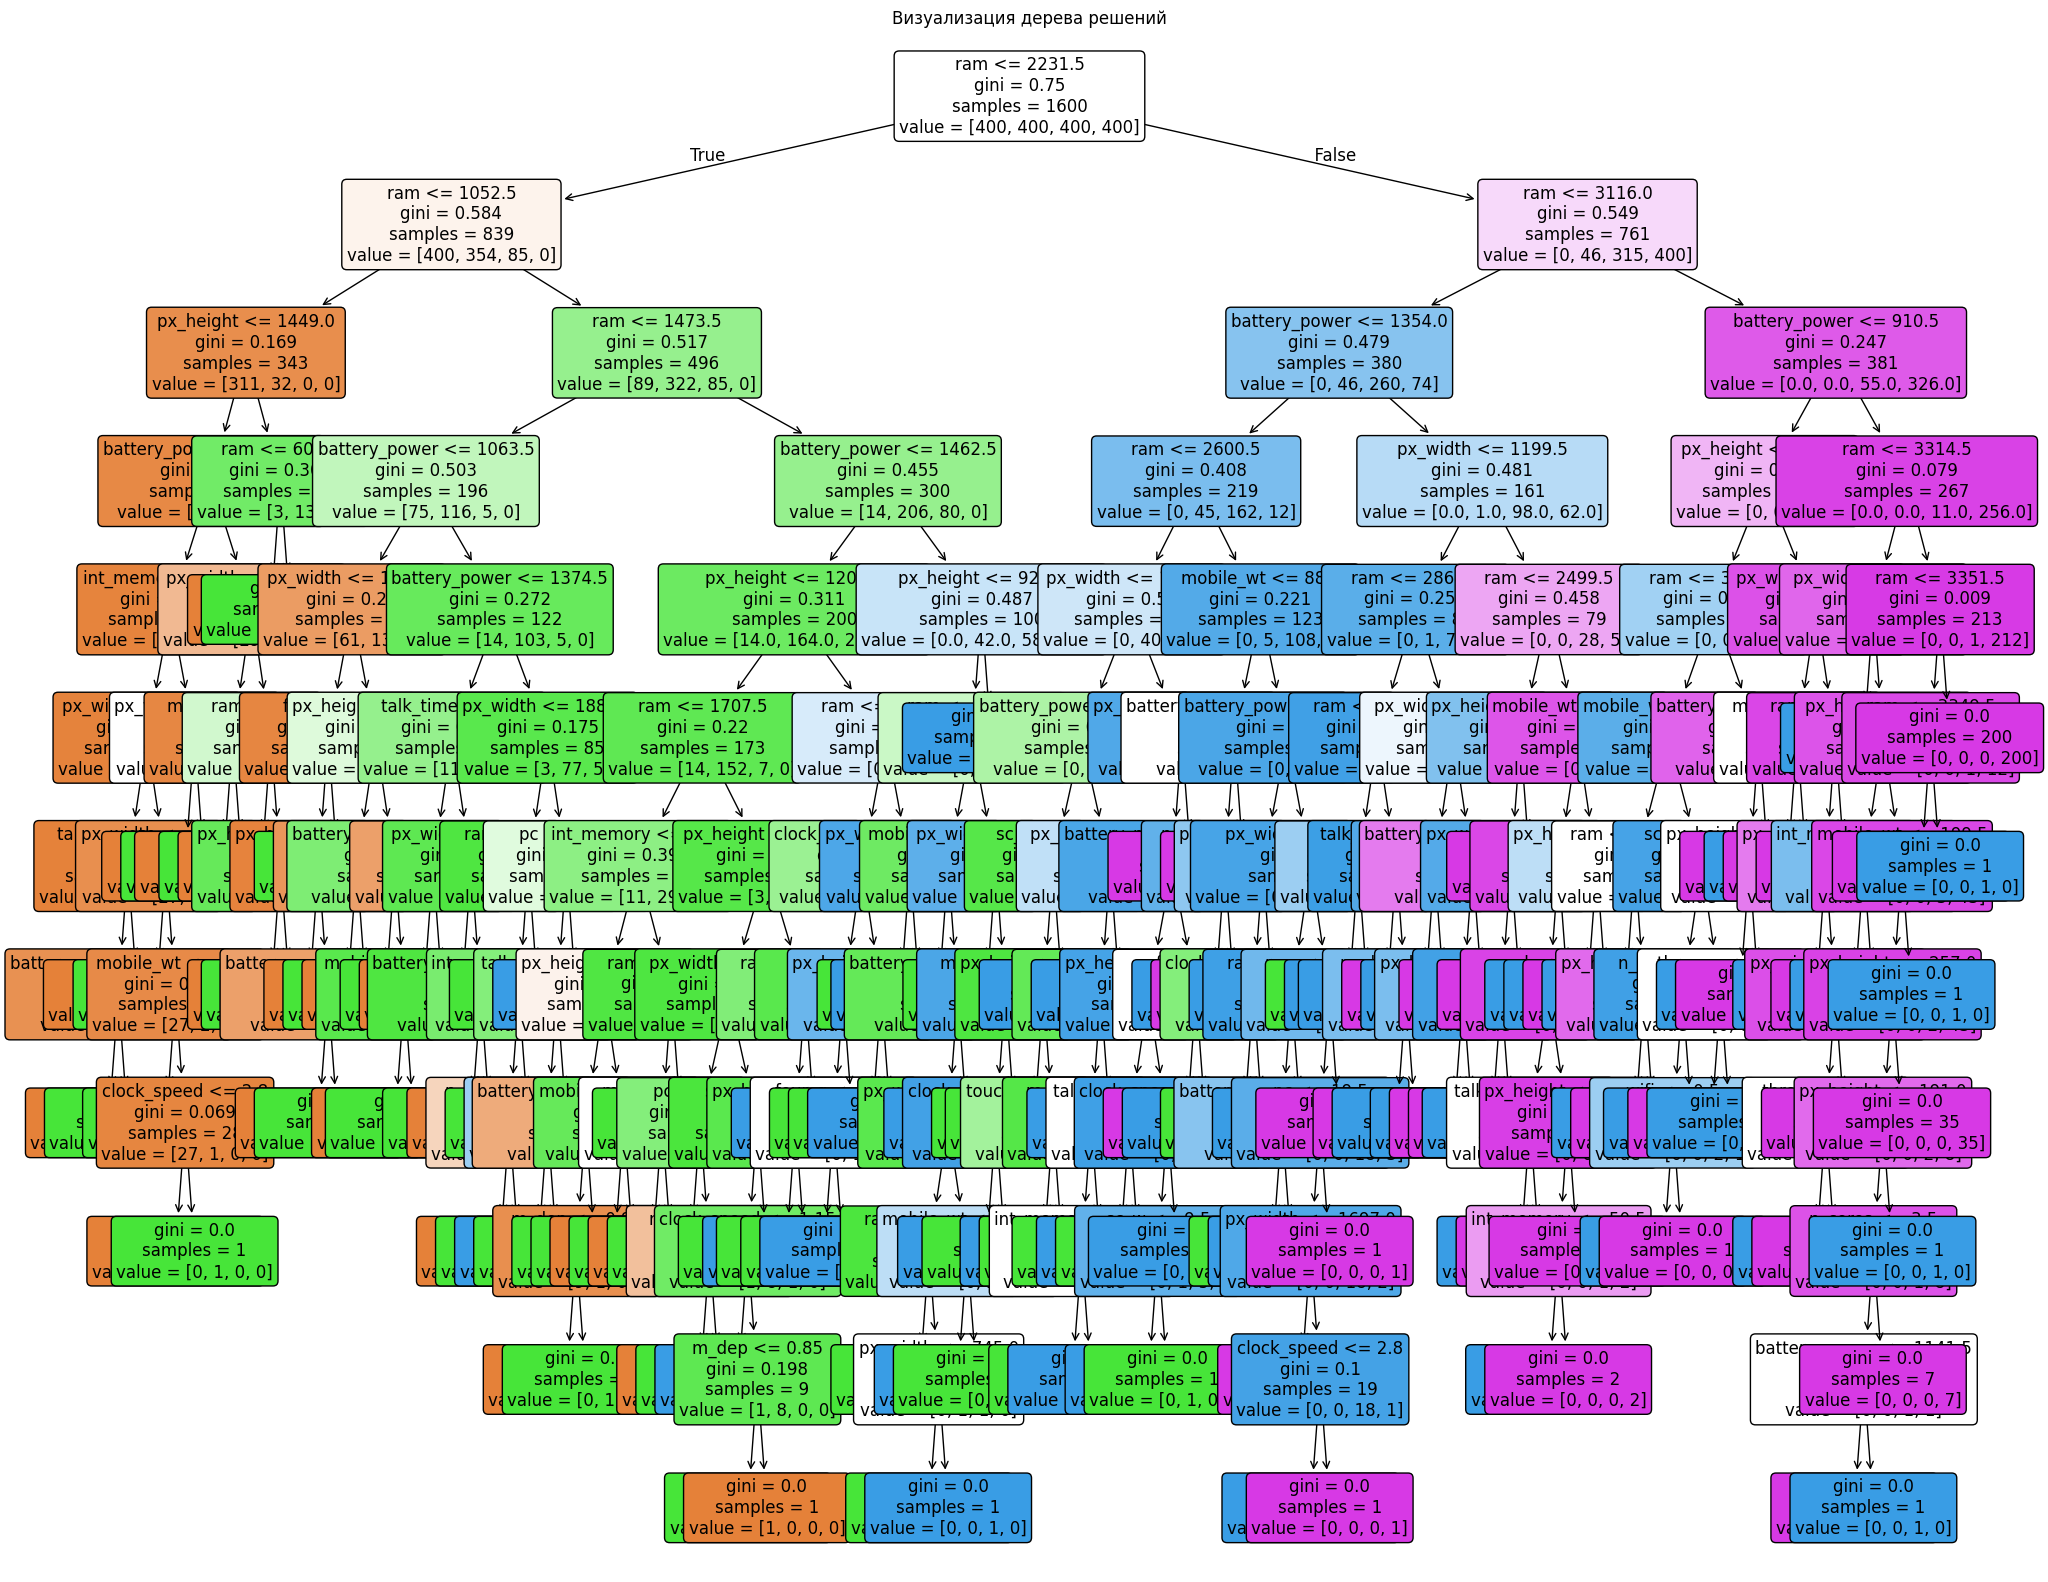

In [120]:
plt.figure(figsize=(24, 20))
plot_tree(clf, filled=True, feature_names=X.columns, rounded=True, fontsize=12)
plt.title("Визуализация дерева решений")
plt.show()

### Важность признаков

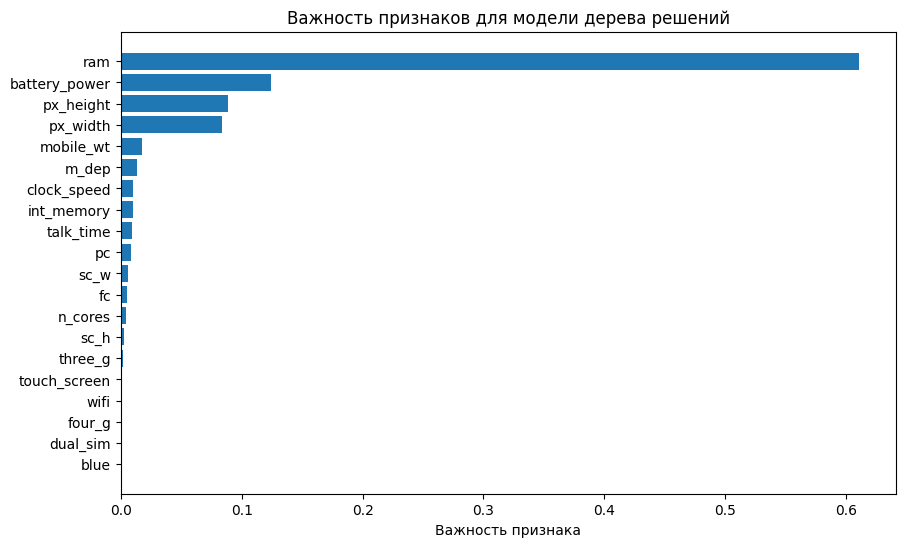

In [121]:
plt.figure(figsize=(10, 6))
feature_importances = clf.feature_importances_
indices = feature_importances.argsort()

plt.barh(range(X.shape[1]), feature_importances[indices], align='center')
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel('Важность признака')
plt.title('Важность признаков для модели дерева решений')
plt.show()

## 6. Нормализация признаков

### StandardScaler


In [122]:
standard_scaler = StandardScaler()

In [123]:
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

In [124]:
X_train_sc_std = standard_scaler.fit_transform(X_train_sc)
X_test_sc_std = standard_scaler.transform(X_test_sc)

In [125]:
clf_standard = DecisionTreeClassifier(random_state=42)
clf_standard.fit(X_train_sc_std, y_train)

DecisionTreeClassifier(random_state=42)

In [126]:
y_pred_std = clf_standard.predict(X_test_sc_std)

In [127]:
print(f"Точность: {accuracy_score(y_test, y_pred_std):.4f}")

Точность: 0.8300


### MinMaxScaler

In [128]:
minmax_scaler = MinMaxScaler()

In [129]:
X_train_sc_mm = minmax_scaler.fit_transform(X_train_sc)
X_test_sc_mm = minmax_scaler.transform(X_test_sc)

In [130]:
clf_minmax = DecisionTreeClassifier(random_state=42)
clf_minmax.fit(X_train_sc_mm, y_train)

DecisionTreeClassifier(random_state=42)

In [131]:
y_pred_minmax = clf_minmax.predict(X_test_sc_mm)

In [132]:
print(f"Точность: {accuracy_score(y_test, y_pred_minmax):.4f}")

Точность: 0.8300


### Вывод

Точность осталась 0.83

## 7. Подбор значений гиперпараметров с помощью RandomizedSearchCV.


In [133]:
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(3, 50),
    'min_samples_split': np.arange(2, 50),
    'min_samples_leaf': np.arange(1, 50),
    'splitter': ['best', 'random']
}

In [134]:
dt = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=100,                # Кол-во итераций
    cv=5,                     # 5-кратная кросс-валидация
    scoring='accuracy',       # Метрика оценки
    random_state=42,
    n_jobs=-1                 # Использовать все ядра
)

In [135]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6..., 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='accuracy')

In [136]:
print("Лучшие параметры:", random_search.best_params_)
print(f"Лучшая точность на валидации: {random_search.best_score_:.4f}")

Лучшие параметры: {'splitter': 'best', 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(7), 'max_depth': np.int64(36), 'criterion': 'entropy'}
Лучшая точность на валидации: 0.8469


*   splitter = 'best' — используется наилучшее разбиение по выбранному критерию. Алгоритм будет выбирать такое разделение данных, которое максимизирует прирост информации (в данном случае по критерию энтропии).

*   min_samples_split = 2 — минимальное количество образцов, необходимое для разделения узла. Значение 2 означает, что узел будет делиться, если в нём не менее двух образцов. Это минимально допустимое значение, что делает дерево потенциально более глубоким и чувствительным к данным.

*   min_samples_leaf = 7 — минимальное количество образцов в листовом узле. Значение 7 предотвращает создание слишком мелких подмножеств, снижая вероятность переобучения.

*   max_depth = 36 — максимальная глубина дерева. Это ограничивает сложность модели, чтобы дерево не стало слишком глубоким, сохраняя баланс между обучением и обобщающей способностью.

*   criterion = 'entropy' — критерий оценки качества разбиений. Энтропия измеряет степень неопределённости в выборке, и модель будет стремиться к разбиениям, уменьшающим эту неопределённость.

## 8. Построение модели с оптимальными параметрами

In [137]:
clf_best = DecisionTreeClassifier(
    splitter='best',
    min_samples_split=2,
    min_samples_leaf=7,
    max_depth=36,
    criterion='entropy',
    random_state=42
)

In [138]:
clf_best.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=36, min_samples_leaf=7,
                       random_state=42)

In [139]:
y_pred_best = clf_best.predict(X_test)

### Точность

In [140]:
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Точность модели: {accuracy:.4f}")

Точность модели: 0.8675


### Матрица ошибок (Confusion Matrix)

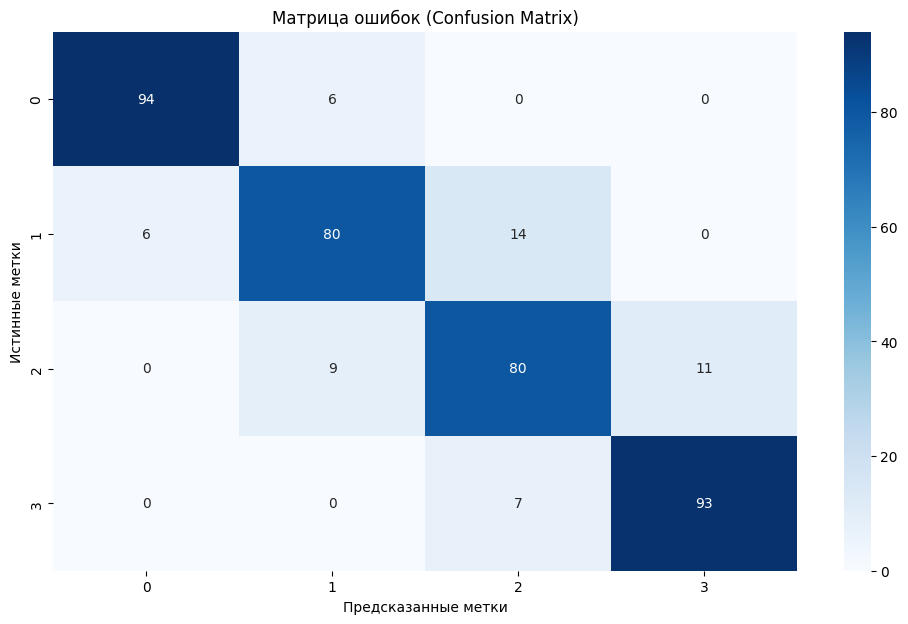

In [141]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

### Отчёт по классификации

In [142]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       100
           1       0.84      0.80      0.82       100
           2       0.79      0.80      0.80       100
           3       0.89      0.93      0.91       100

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



### Вывод

Модель с оптимизированными гиперпараметрами показала точность 0.8675, что является улучшением по сравнению с предыдущими результатами. Прогресс обусловлен правильной настройкой гиперпараметров с использованием RandomizedSearchCV, что позволило модели эффективно различать классы.

Деревья решений для классификации показывают хорошие результаты на различных типах данных, включая этот набор с характеристиками мобильных устройств. Модель продемонстрировала точность 0.8675, что говорит о ее способности эффективно классифицировать устройства по категориям. Однако при глубоком дереве или недостаточной настройке гиперпараметров существует риск переобучения, когда модель слишком точно подстраивается под тренировочные данные и теряет способность обрабатывать новые данные. В этом случае важно ограничить глубину дерева или количество образцов в листьях. При применении к данному набору данных, деревья решений хорошо справляются с распознаванием классов 0 и 3, но для классов 1 и 2 остаётся пространство для улучшения

## 9. Ансамблевые методы

### Случайный лес RandomForestClassifier

In [143]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [144]:
y_pred_rf = rf_clf.predict(X_test)

In [145]:
# Оцениваем точность
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Точность модели Random Forest: {accuracy:.4f}")

Точность модели Random Forest: 0.8800


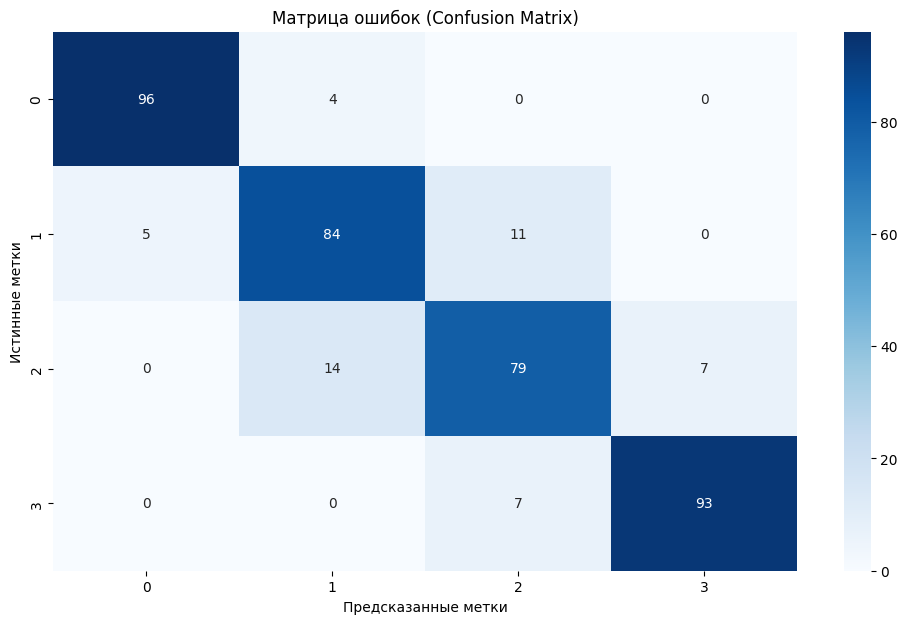

In [146]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

In [147]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.82      0.84      0.83       100
           2       0.81      0.79      0.80       100
           3       0.93      0.93      0.93       100

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



По сравнению с результатами после подбора гиперпараметров для дерева решений, где точность составила 0.8675, использование базового RandomForestClassifier дало более высокую точность — 0.8800. Также улучшились и метрики по отдельным классам: модель чуть точнее определяет классы 0 и 3, а по классам 1 и 2 наблюдается небольшое, но заметное повышение f1-оценок. Это демонстрирует преимущество ансамблевого подхода: за счёт объединения предсказаний множества деревьев удаётся добиться лучшего обобщения и устойчивости модели, особенно на гетерогенных или неидеально сбалансированных данных.

### AdaBoostClassifier

In [148]:
ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [149]:
y_pred_ada = ada_clf.predict(X_test)

In [150]:
# Оцениваем точность
accuracy = accuracy_score(y_test, y_pred_ada)
print(f"Точность модели AdaBoost: {accuracy:.4f}")

Точность модели AdaBoost: 0.4900


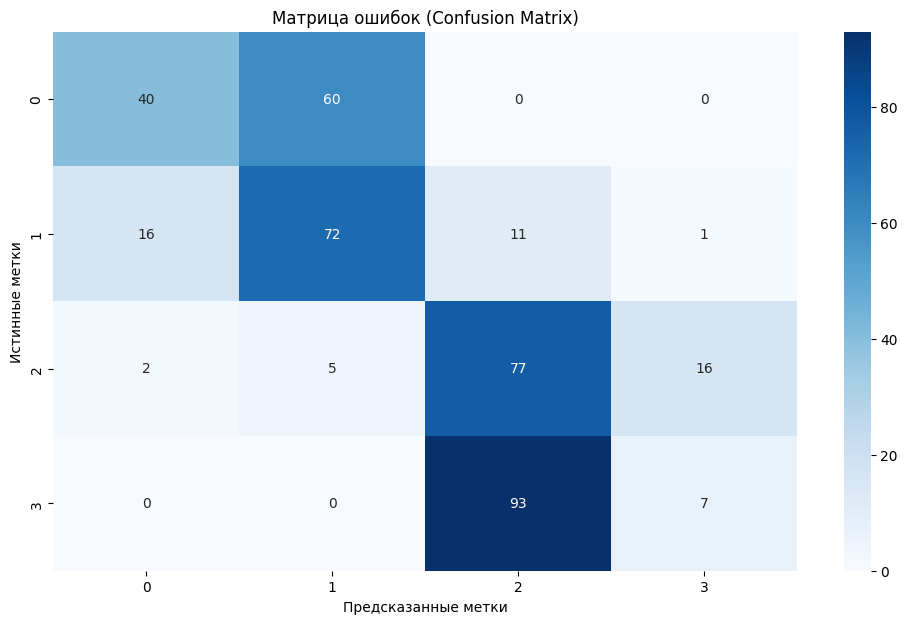

In [151]:
cm = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

In [152]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.69      0.40      0.51       100
           1       0.53      0.72      0.61       100
           2       0.43      0.77      0.55       100
           3       0.29      0.07      0.11       100

    accuracy                           0.49       400
   macro avg       0.48      0.49      0.44       400
weighted avg       0.48      0.49      0.44       400



Результаты модели AdaBoost показывают точность 0.4900, что значительно ниже, чем у предыдущих моделей, таких как Decision Tree (0.8675) и Random Forest (0.8800).

### GradientBoostingClassifier (HistGradientBoostingClassifier)

In [153]:
hist_gb_clf = HistGradientBoostingClassifier(random_state=42)
hist_gb_clf.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [154]:
y_pred_hist_gb = hist_gb_clf.predict(X_test)

In [155]:
# Оцениваем точность
accuracy = accuracy_score(y_test, y_pred_hist_gb)
print(f"Точность модели HistGradientBoosting: {accuracy:.4f}")

Точность модели HistGradientBoosting: 0.9450


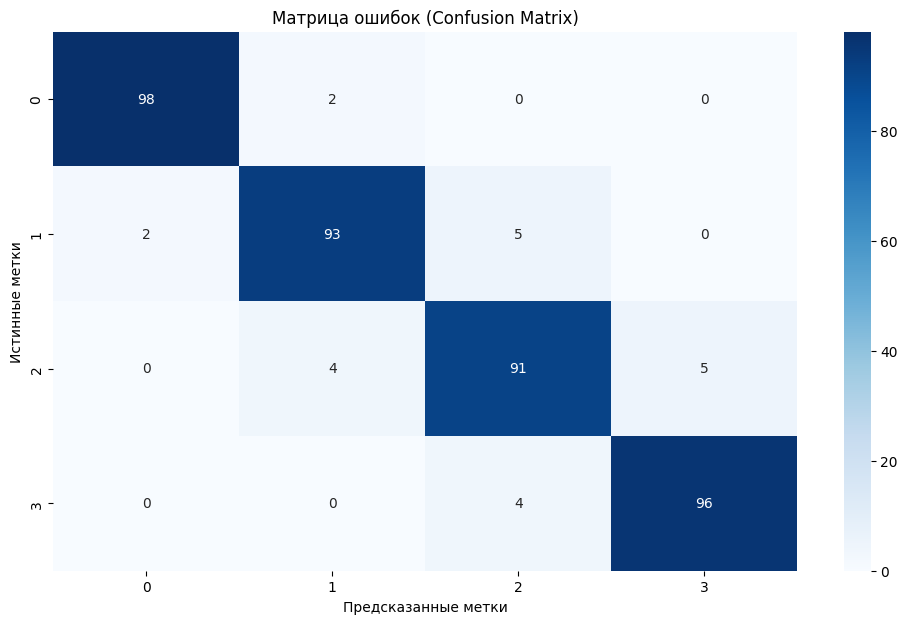

In [156]:
cm = confusion_matrix(y_test, y_pred_hist_gb)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

In [157]:
print(classification_report(y_test, y_pred_hist_gb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       100
           1       0.94      0.93      0.93       100
           2       0.91      0.91      0.91       100
           3       0.95      0.96      0.96       100

    accuracy                           0.94       400
   macro avg       0.94      0.95      0.94       400
weighted avg       0.94      0.94      0.94       400



Модель HistGradientBoosting показала отличные результаты с точностью 0.9450, что значительно превосходит другие модели, включая Decision Tree (0.8675), Random Forest (0.8800) и AdaBoost (0.4900). Модель продемонстрировала высокую точность по всем классам, особенно в классе 0, где точность составляет 0.98, а recall — 0.98. Также заметен очень хороший результат для классов 2 и 3, с точностью около 0.91-0.95.

Этот результат подтверждает, что HistGradientBoostingClassifier отлично справляется с задачей классификации в этом наборе данных и значительно опережает другие методы. Высокая точность и хорошие значения по меткам свидетельствуют о том, что модель умеет эффективно обрабатывать сложные зависимости и классифицировать объекты в разные категории

## 10. Stacking

### RandomForestClassifier

In [158]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

### SVC

In [159]:
svc_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svc_random = RandomizedSearchCV(
    SVC(random_state=42),
    svc_params,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)


### DecisionTreeClassifier

In [160]:
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_random = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

### HistGradientBoostingClassifier

In [161]:
hgb_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0.0, 0.1, 0.5, 1.0]
}

# RandomizedSearchCV
hgb_random = RandomizedSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    hgb_params,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

### Лучшие параметры

In [162]:
rf_random.fit(X_train, y_train)
svc_random.fit(X_train, y_train)
dt_random.fit(X_train, y_train)
hgb_random.fit(X_train, y_train)

print("Лучшие параметры для RandomForest:", rf_random.best_params_)
print("Лучшие параметры для SVC:", svc_random.best_params_)
print("Лучшие параметры для DecisionTree:", dt_random.best_params_)
print("Лучшие параметры для HistGradientBoostingClassifier:", hgb_random.best_params_)

Лучшие параметры для RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}
Лучшие параметры для SVC: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Лучшие параметры для DecisionTree: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'entropy'}
Лучшие параметры для HistGradientBoostingClassifier: {'min_samples_leaf': 20, 'max_iter': 200, 'max_depth': None, 'learning_rate': 0.2, 'l2_regularization': 0.5}


Лучшие параметры для **RandomForest**: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}

Лучшие параметры для **SVC**: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}

Лучшие параметры для **DecisionTree**: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'entropy'}
Лучшие параметры для **HistGradientBoostingClassifier**: {'min_samples_leaf': 20, 'max_iter': 200, 'max_depth': None, 'learning_rate': 0.2, 'l2_regularization': 0.5}

In [163]:
print("Лучшая точность для RandomForest:", rf_random.best_score_)
print("Лучшая точность для SVC:", svc_random.best_score_)
print("Лучшая точность для DecisionTree:", dt_random.best_score_)
print("Лучшая точность для HistGradientBoostingClassifier:", hgb_random.best_score_)

Лучшая точность для RandomForest: 0.8649940388772945
Лучшая точность для SVC: 0.968126146257141
Лучшая точность для DecisionTree: 0.8468846399786383
Лучшая точность для HistGradientBoostingClassifier: 0.8987522632356834


### Объединение (Stacking)

In [164]:
# Лучшие модели
rf_best = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2,
                                 max_depth=30, bootstrap=True, random_state=42)
svc_best = SVC(kernel='linear', gamma='scale', C=0.1, probability=True, random_state=42)
dt_best = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=2,
                                 max_depth=20, criterion='entropy', random_state=42)

hgb =  HistGradientBoostingClassifier(min_samples_leaf=20,  max_iter=200,
                                      max_depth=None,  learning_rate=0.2,
                                      l2_regularization=0.5, random_state=42)

base_learners = [
    ('rf', rf_best),
    ('svc', svc_best),
    ('dt', dt_best),
    ('hgb', hgb)
]

In [165]:
# Мета-модель
meta_model = LogisticRegression()

In [166]:
# Создание модели Stacking
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_model)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=30,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('svc',
                                SVC(C=0.1, kernel='linear', probability=True,
                                    random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=20,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('hgb',
                                HistGradientBoostingClassifier(l2_regularization=0.5,
                                                               learning_rate=0.2,
                                                               max_iter=200,
                                                               random_state=42))],
                   final_estimator=LogisticRegression())

In [167]:
# Предсказания
y_pred_stacking = stacking_clf.predict(X_test)

In [168]:
# Оцениваем точность
accuracy = accuracy_score(y_test, y_pred_stacking)
print(f"Точность модели Stacking: {accuracy:.4f}")

Точность модели Stacking: 0.9775


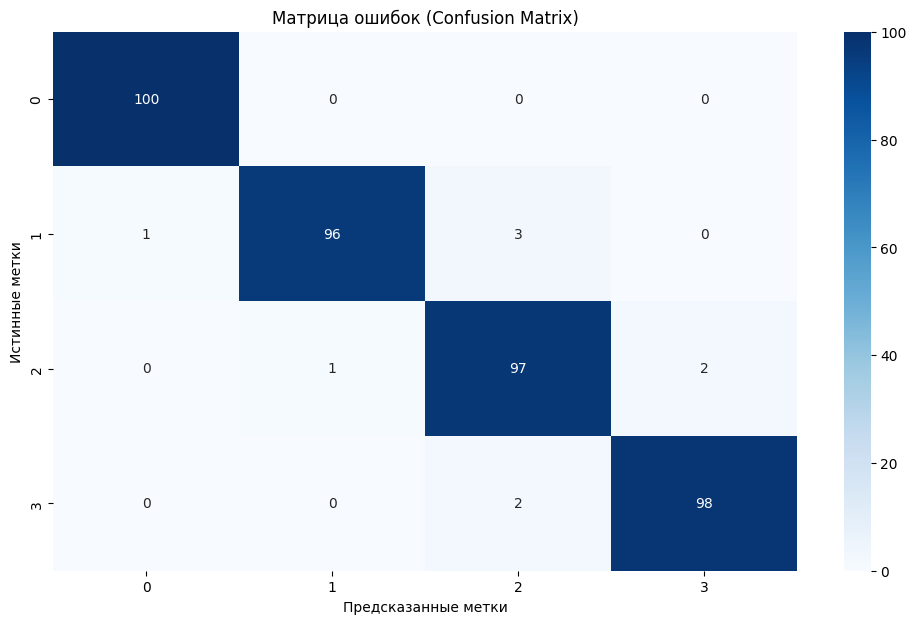

In [169]:
cm = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

In [170]:
print(classification_report(y_test, y_pred_stacking))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       0.99      0.96      0.97       100
           2       0.95      0.97      0.96       100
           3       0.98      0.98      0.98       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



Модель стекинга с настроенными гиперпараметрами показала высокую точность — 0.9775, что значительно превышает результаты предыдущих моделей, включая одиночные деревья решений и методы бустинга. Особенно хорошо классифицируются объекты классов 0 и 3, где f1-оценка достигает 1.00 и 0.98 соответственно. Для классов 1 и 2 показатели также остаются на высоком уровне, однако всё ещё есть незначительное пространство для улучшения. Такие результаты демонстрируют эффективность ансамблевых методов, объединяющих сильные стороны различных алгоритмов в одной модели.

**Stacking** — это метод ансамблирования, при котором предсказания нескольких различных моделей объединяются с помощью финальной мета-модели, чтобы получить более точный результат. Он позволяет учитывать сильные стороны разных алгоритмов, повышая итоговую точность. Основные преимущества стекинга — высокая точность, устойчивость к переобучению и гибкость в выборе моделей. Однако он требует значительных вычислительных ресурсов, тщательной настройки гиперпараметров и хуже поддается интерпретации по сравнению с одиночными моделями. Метод особенно полезен, когда важно добиться максимальной точности и имеются разные сильные модели для объединения.